# SLAM

In [1]:
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt
from scipy.linalg import det, expm, inv, sqrtm
from numpy.random import randn
import matplotlib.animation as animation

%matplotlib notebook

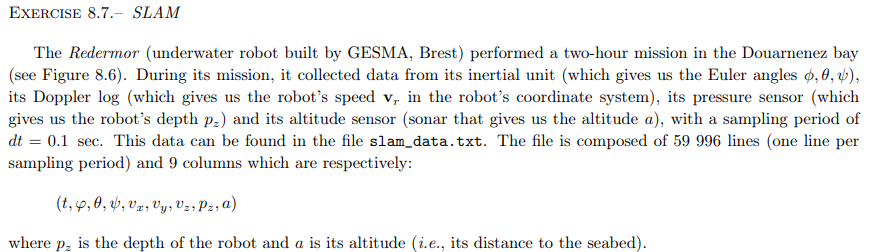

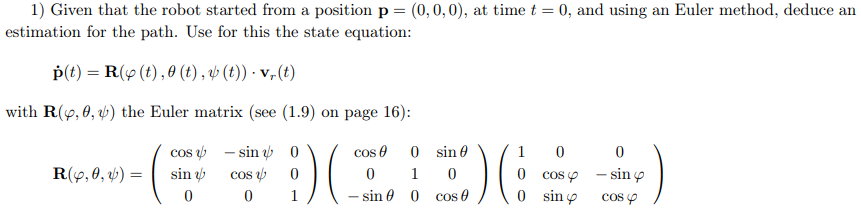

In [2]:
# load the slam data
def loadcsv(file1):
    fichier = open(file1, 'r')
    D = fichier.read().split("\n")
    fichier.close()
    for i in range(len(D)):
        D[i] = D[i].split(";")
    D = np.array([[float(elt) for elt in Ligne] for Ligne in D])
    return D

DATA = loadcsv("slam_data.csv")

In [3]:
def rotate(p):
    """
    rotation matrix in respect to p = (phi, theta, psi)
    :param p: (phi, theta, psi)
    :return : rotation matrix 
    """
    phi, theta, psi = p
    A = np.array([[cos(psi), - sin(psi), 0],
                  [sin(psi), cos(psi), 0],
                  [0, 0, 1]], dtype='float')
    B = np.array([[cos(theta), 0, sin(theta)],
                  [0, 1, 0],
                  [-sin(theta), 0, cos(theta)]], dtype='float')
    C = np.array([[1, 0, 0],
                  [0, cos(phi), -sin(phi)],
                  [0, sin(phi), cos(phi)]], dtype='float')
    return A @ B @ C


Euler's method :

$$X_{k+1} = X_{k} + dt.f(X_{k})$$
With $f = \overset{.}{X}$ and $dt<<1$ 

In [4]:
def euler(data, f=rotate):
    """
    Euler's method
    :param data: data extracted from csv list, each element being a list :[0] -> timstamp, [1:4]->rot angle, [4:7]-> velocity
    :param f: rotate function
    :return X: array of cartesian position for each timestamp 
    """
    X = np.zeros((3, len(data)))
    dt = data[1][0] - data[0][0]
    for i in range(len(data)):
        pos = data[i][1:4]
        vel = data[i][4:7]
        X[:, i] = X[:, i - 1] + dt * f(pos) @ vel
    return X

<IPython.core.display.Javascript object>


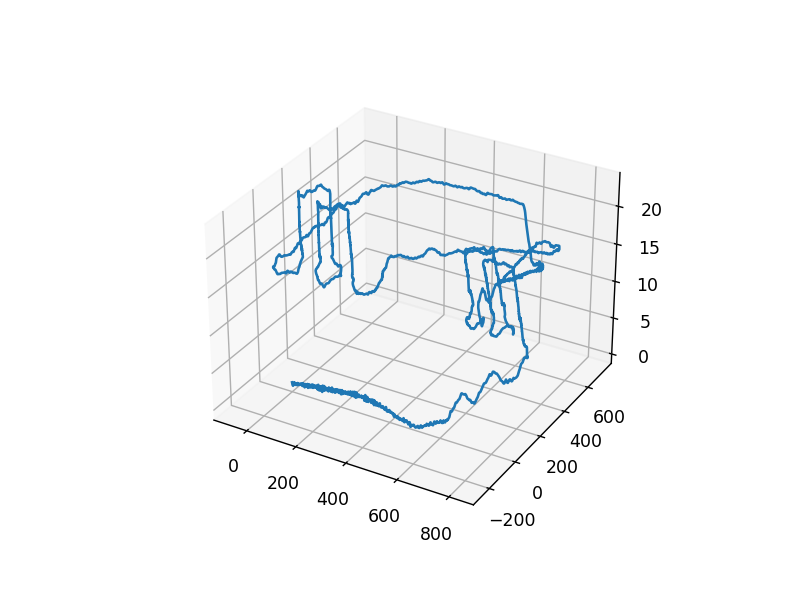

In [5]:
# Plotting the path

X = euler(DATA)
ax = plt.axes(projection='3d')
x, y, z = [], [], []
for i in range(np.shape(X)[1]):
    a, b, c = X[:, i]
    x.append(a)
    y.append(b)
    z.append(c)

ax.plot3D(x, y, z)
plt.show()

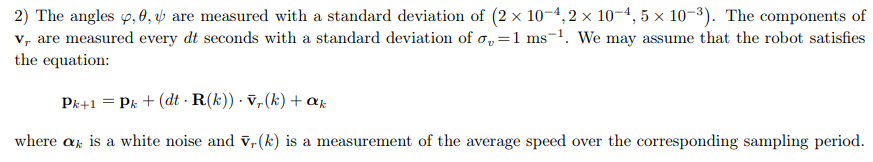


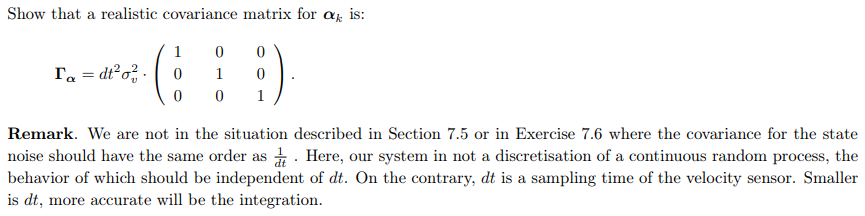

__ANSWER__

Position noise $\alpha_{k} $is related to velocity noise $ \alpha_{v,k}$, according to :

$$p_{k+1} = p_{k} + dt.R(k)(\overset{-}{v_{r}}(k) + \alpha_{v,k})$$
$$ = p_{k} + dt.R(k)\overset{-}{v_{r}}(k) + dt.R(k)\alpha_{v, k}$$
So 
$$\alpha_{k} = dt.R(k)\alpha_{v, k}$$

Therefore :
$$\Gamma_{\alpha} = (dt.R(k))\Gamma_{\alpha_{v}}(dt.R(k))^{T}$$
And since, according to the description $\Gamma_{\alpha_{v}} = \alpha_{v} I_{3} = \sigma_{v}^{2} I_{3} $ (with $\sigma_{v} = 10^{-3}s$), we have :

$$\Gamma_{\alpha} = \sigma_{v}^{2}.dt^{2}.R(k).I_{3}.R(k)^{T}$$
$$\implies \Gamma_{\alpha} = \sigma_{v}^{2}.dt^{2}.I_{3}$$ by orthogonality of $R(k)$

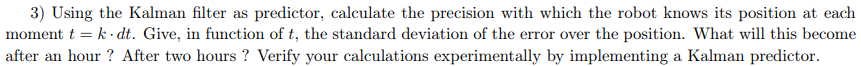

__ANSWER__

According to the Euler's method, $A_{k} = I_{3}$ (indeed $p_{k+1} = A.p_{k} + u_{k} + \alpha_{k} = I.p_{k} + dt.R(k)\overset{-}{v_{r}}(k) + \alpha_{k}$).
So using the Prediction equation, we have :
$$\Gamma_{k+1} = \Gamma_{k} + \Gamma_{\alpha}$$
Giving : 
$$\Gamma_{k} = \Gamma_{0} + k.\Gamma_{\alpha} = k.\Gamma_{\alpha} $$
(no uncertainty on position at t=0)

At t = k.dt, we finally have :

$$\Gamma_{t} = t.dt.\sigma_{v}^{2}.I_{3}$$

Therefore the error deviation $\sigma$ (taken on diag($\Gamma$)) is $\sqrt{dt}\sigma_{v}.\sqrt{t} \simeq 0.3.\sqrt{t}$.
After an hour, $\sigma = 18m$.

In [6]:
def kalman_prediction(xc, G_x, A, u, alpha, G_alpha):
    xc = A@xc + u + alpha
    G_x = A@G_x@A.T + G_alpha
    return xc, G_x

dt, sig = 0.1, 1
I = np.eye(3)

p_hat = np.zeros((3, 1))
A = I
cov_p = 0 * I
cov_alpha = dt ** 2 * sig ** 2 * I
alpha = cov_alpha @ randn(len(p_hat), 1)

sd = [] # standard deviation

for i in range(1, len(DATA)):
    v_bar = DATA[i][4:7].reshape(3, 1)
    u = dt * rotate(p_hat) @ v_bar
    p_hat, cov_p = kalman_prediction(p_hat, cov_p, A, u, alpha, cov_alpha)

    sd.append(np.sqrt(np.diag(cov_p)))

def standard_deviation(t, tab=sd):
    return tab[int(t / 0.1)]

print('std(1 hour): ', standard_deviation(3600))

C:\Users\alexa\AppData\Local\Temp/ipykernel_12200/40396656.py:8: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A = np.array([[cos(psi), - sin(psi), 0],
C:\Users\alexa\AppData\Local\Temp/ipykernel_12200/40396656.py:11: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  B = np.array([[cos(theta), 0, sin(theta)],
C:\Users\alexa\AppData\Local\Temp/ipykernel_12200/40396656.py:14: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a singl

std(1 hour):  [18.97392948 18.97392948 18.97392948]


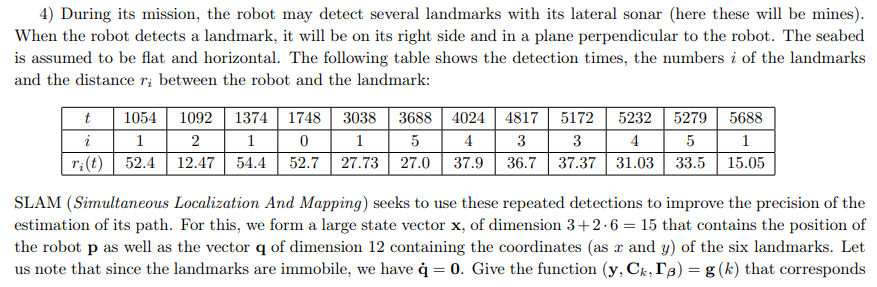

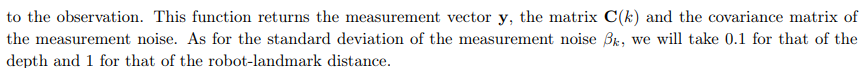

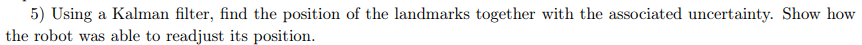

Wa note 
$$X = 
\left[ {\begin{array}{c}
    p_{x}\\
    p_{y}\\
    p_{z}\\
    x_{1}\\
    y_{1}\\
    .\\
    .\\
    .\\
    x_{6}\\
    y_{6}\\
  \end{array} } \right] 
 $$
With $x_{i}, y_{i}$ the planar coordinates of the landmark $a_{i}$.
First we have to distinguish 2 cases, the one when the robot detects a landmark, and the one when it dosn't detect any.

## Case 1 : No landmark detected

The only information available comes from the pressure sensor, and is $p_{z}$.
Therefore :
$$y = p_{z} = [0 \ 0 \ 1 \ 0 ... 0].X$$

## Case 2 : Landmark detected

Assuming the landmark $a_{i}$ is detected, 2 additional information are available $(p-a_{i})_{x}$ and $(p-a_{i})_{y}$.

Therefore the measurement relation is :

$$
  y =
  \left[ {\begin{array}{c}
    y_{1}\\
    y_{2}\\
    y_{3}\\
  \end{array} } \right]
  =
  \left[ {\begin{array}{cccccccccc}
    1 & 0 & 0 & 0 & ... &-1 & 0 & ... & ... & 0\\
    0 & 1 & 0 & 0 & ... & 0 &-1 & 0 & ... & 0\\
    0 & 0 & 1 & 0 & ... & ... & ... & ...& ... & 0\\
  \end{array} } \right].X
$$
The -1 coefficients are on columns (3+i) and (4+i) when landmark $a_{i}$ is detected.
    

In [7]:
def kalman_correction(xc, y, C, G_x, G_b):
    yt = y - C @ xc
    G_y = C @ G_x @ C.T + G_b
    K = G_x @ C.T @ np.linalg.inv(G_y)
    xc = xc + K @ yt
    G_x = G_x - K @ C @ G_x
    return xc, G_x


def eps(G, eta, mean=0, color = 'blue'):
    """
    Confidence ellipse plotting (cf lab complete kalman)
    """
    a = np.sqrt(-2 * np.log(1 - eta))
    theta = np.linspace(0, 2 * np.pi, 100)

    w = np.repeat(mean, 100, axis=1)
    sq = sqrtm(G)
    W = w + a * sq @ np.array([np.cos(theta), np.sin(theta)])

    X = W[0]
    Y = W[1]
    plt.plot(X, Y, color = color)

We initialize the vector X (shape (15,1)) as the null vector :

$$\hat{X} = 
    \left[ {\begin{array}{c}
    0\\
    .\\
    .\\
    .\\
    0\\
  \end{array} } \right] 
$$
There is no uncertainty on the position $p_{x}, p_{y} ,p_{z} $ but a huge one the landmarks localization, so :

$$\Gamma_{X} =
    10^{6}. 
    \left[ {\begin{array}{cc}
    0_{3\times3} & 0_{3\times12} \\
    0_{12\times3} & I_{12} \\
  \end{array} } \right]
$$

There exists a positional white gaussian noise of variance 0.01, but no noise on the landmark position (they don't move).

So :

$$\Gamma_{\alpha} =
    0.01. 
    \left[ {\begin{array}{cc}
    I_{3\times3} & 0_{3\times12} \\
    0_{12\times3} & 0_{12} \\
  \end{array} } \right]
$$

We have $A = I_{15}$, from Euler's method.

In [8]:
# distinguishing the two cases of landmark detection

def g(k):
    """
    computes at each time step y, C and cov_beta
    """
    t, phi, theta, psi, vx, vy, vz, pz, a = DATA[k]
    y = pz # depth of the robot
    
    #case 1 : no landmark detected
    C = np.zeros((1, 15))
    C[0, 2] = 1
    cov_beta = 0.01

    T = np.array([[1054, 1092, 1374, 1748, 3038, 3688, 4024, 4817, 5172, 5232, 5279, 5688],
                 [1, 2, 1, 0, 1, 5, 4, 3, 3, 4, 5, 1],
                 [52.4, 12.47, 54.4, 52.7, 27.73, 27.0, 37.9, 36.7, 37.37, 31.03, 33.5, 15.05]])
    
    
    j = list(np.where(T[0, :] == t)[0])
    
    # checking if landmark is detected at current time step
    # computes parameters according to case 2
    if j:
        j = int(j[0])
        r = T[2, j]
        Rk = rotate([phi, theta, psi])
        e = Rk @ np.array([[0], [-np.sqrt(r**2 - a**2)], [-a]])
        y = np.block([[e[0:2]], [y]])
        C = np.block([[np.zeros((2, 15))], [C]])
        jm = 3 + 2 * int(T[1, j])
        C[0, 0], C[0, jm] = 1, -1
        C[1, 1], C[1, jm + 1] = 1, -1
        cov_beta = np.diag([1, 1, 0.01])

    return y, C, cov_beta

<IPython.core.display.Javascript object>


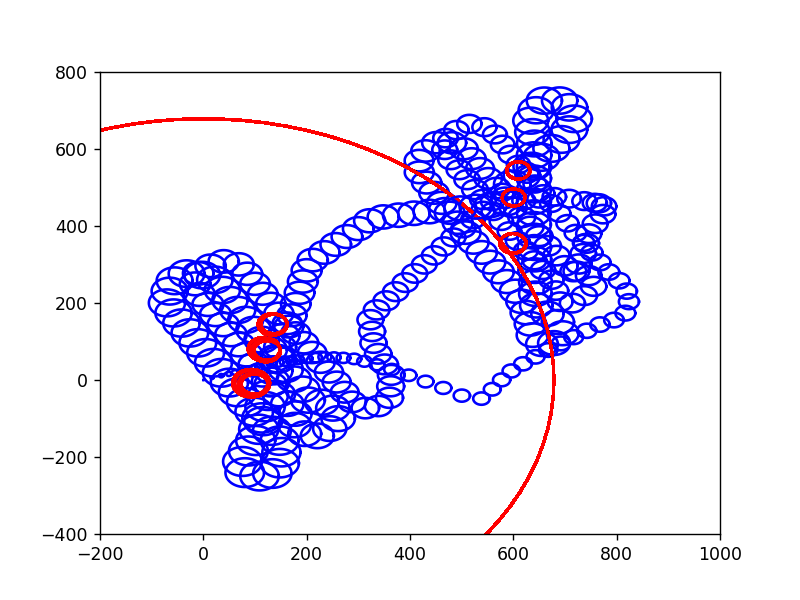

Landmark position 1: (598.9208161767182, 355.0273131407342)
Landmark position 2: (600.4445011067219, 473.90634693908044)
Landmark position 3: (609.4591102988528, 544.1491705227988)
Landmark position 4: (99.35316818652868, -10.663268103875849)
Landmark position 5: (123.61104887508074, 76.74522983797267)
Landmark position 6: (136.3466937130952, 145.57536142457158)


In [9]:
T = np.array([[1054, 1092, 1374, 1748, 3038, 3688, 4024, 4817, 5172, 5232, 5279, 5688],
            [1, 2, 1, 0, 1, 5, 4, 3, 3, 4, 5, 1],
            [52.4, 12.47, 54.4, 52.7, 27.73, 27.0, 37.9, 36.7, 37.37, 31.03, 33.5, 15.05]])
t = T[0]
ai = T[1]
r = T[2]
dt = 0.1
x_hat = np.zeros((15, 1))
cov_x = np.diag(3 * [0] + 12 * [10**5])

cov_alpha = np.diag(3 * [0.01] + 12 * [0])
alpha = 0
A = np.eye(15)

plt.figure()
plt.xlim([-200, 1000])
plt.ylim([-400, 800])

# filtering at each timestep and plotting confidence ellipse
for i in range(len(DATA)):
    v_bar = DATA[i][4:7].reshape(3, 1)
    u = np.block([[dt * rotate(DATA[i][1:4]) @ v_bar], [np.zeros((12, 1))]])
    y, C, cov_beta = g(i)
    x_hat, cov_x = kalman_correction(x_hat, y, C, cov_x, cov_beta)
    x_hat, cov_x = kalman_prediction(x_hat, cov_x, A, u, alpha, cov_alpha)
    if (i%200==0):
        eps(cov_x[0:2, 0:2], 0.9, mean = x_hat[0:2], color = 'blue')
        for n in range(3, len(x_hat)-1, 2):
            eps(cov_x[n:n+2, n:n+2], 0.9, mean=x_hat[n:n+2], color = 'red')


# landmark positions
for i in range(3, len(x_hat)-1, 2):
    print(f'Landmark position {int(1+(i-3)/2)}: ({x_hat[i][0]}, {x_hat[i+1][0]})')